<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     width="30%"
     alt="Dask logo\">

# Dask

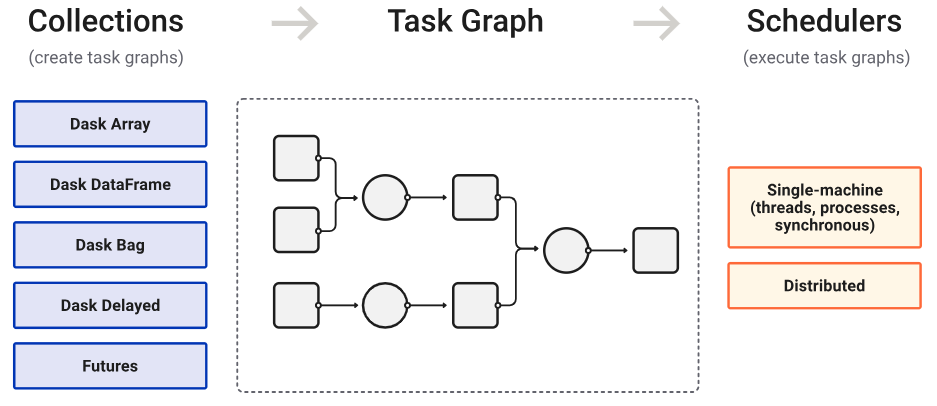

## Local Cluster

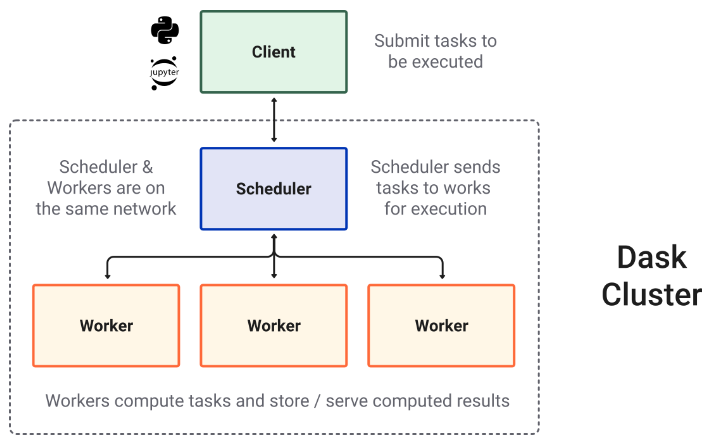

Let's explore the `LocalCluster` object ourselves and see what it is doing.

In [13]:
from dask.distributed import LocalCluster, Client

In [ ]:
cluster = LocalCluster(n_workers=4)
cluster

We can access the url that the Dask dashboard is being hosted at.

In [ ]:
# Check this page when you run computations with Dask
cluster.dashboard_link

In order for Dask to use our cluster we still need to create a `Client` object, but as we have already created a cluster we can pass that directly to our client.

In [ ]:
client = Client(cluster)
client

We can assign a specific Client to a function in order to access the correct cluster during the execution.

In [17]:
def current_client(func):
    def _wrapper():
        with client.as_current():
            return func()
    return _wrapper

## Docker cluster

Compose example:

```yaml
  dask-scheduler:
    build:
      context: .
      dockerfile: ./docker/dask/Dockerfile
    image: "harbor.gradiant.org/project/dask:latest"
    hostname: dask-scheduler
    container_name: dask-scheduler
    ports:
      - "8888:8888"
      - "8899:8899"
    command: "dask scheduler --port 8888 --dashboard-address 0.0.0.0:8899"

  dask-worker:
    build:
      context: .
      dockerfile: ./docker/dask/Dockerfile
    image: "harbor.gradiant.org/project/dask:latest"
    hostname: dask-worker
    container_name: dask-worker
    command: "dask worker tcp://dask-scheduler:8888 --nworkers 8 --nthreads 2"
    depends_on:
      - dask-scheduler
```

Python code:

```python
client = Client("tcp://dask-scheduler:8888")
client.submit(lambda: 1+1)
```

## Scalable clusters

Dask has cluster managers for Kubernetes, Hadoop/Yarn, cloud platforms and batch systems including PBS, SLURM and SGE.

## Delayed

In [18]:
import dask
from time import sleep

In [19]:
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Running function sequentially

In [27]:
def double(x):
    sleep(1)
    return 2 * x

def inc(x):
    sleep(1)
    return x + 1

def is_even(x):
    return not x % 2

def func_sequentially():
    results = []
    for x in data:
        if is_even(x):  # even
            y = double(x)
        else:  # odd
            y = inc(x)
        results.append(y)

    return sum(results)

In [ ]:
%%time
total = func_sequentially()
total

@delayed allow functions to be  planified and parallelized by Dask

In [28]:
@dask.delayed
def double(x):
    sleep(1)
    return 2 * x

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1

def is_even(x):
    return not x % 2

@current_client
def func_to_parallel():
    results = []
    for x in data:
        if is_even(x):  # even
            y = double(x)
        else:  # odd
            y = inc(x)
        results.append(y)

    return sum(results)

In [ ]:
%%time
total = func_to_parallel()
total.compute()

Until .compute(), it does not execute anything

In [ ]:
total.visualize()

# Futures

Futures allow submitting functions asyncronously to be executed through the cluster

In [30]:
def double(x):
    sleep(1)
    return 2 * x

def inc(x):
    sleep(1)
    return x + 1

def is_even(x):
    return not x % 2

def handle_item(x):
    if is_even(x):  # even
        y = double(x)
    else:  # odd
        y = inc(x)
    return y

@current_client
def func_to_parallel():
    futures = []
    for x in data:
        future = client.submit(handle_item, x)
        futures.append(future)

    return sum(client.gather(futures))

In [ ]:
%%time
total = func_to_parallel()
total
